**Notebook 3: Testing highly variable genes**

Goal: Compare different methods for identifying highly variable genes (built into scanpy) and identifying optimal number of features to use

1. Load training dataset with original labels
2. Create cross-fold splits using StratifiedGroupKFold
3. Select highly variable genes using seurat_v3, seurat (v1), Cell Ranger, or analytic Pearson residuals methods
4. Train model using top 20, 50, 100, 200, 500, 1000, 2000, or 5000. Also do the same for randomly selected genes (randomize order of all genes and select top N genes) and differential gene expression.
5. Plot all evaluation metrics for all approaches

In [ ]:
from main_functions import *
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score,\
                            balanced_accuracy_score, matthews_corrcoef, roc_auc_score, average_precision_score
import shap

In [ ]:
# Constants
RANDOM_STATE = 42
CV = 5

In [ ]:
# Set up working directory
folder_path = input('Please enter the path of the folder containing datasets: ')
os.chdir(folder_path)

In [ ]:
# Load training dataset into AnnData object
adata_train = sc.read_h5ad('train.h5ad')

Dataset has 33043 cells and 22830 features
Size of raw dataset: 
Size: 554.77 MB
Size of normalized dataset:
Size: 558.64 MB


In [ ]:
# Variables for training
clf = XGBClassifier(eta = 0.3, max_depth = 2, n_estimators = 100, max_iter = 500)
num_features = [20, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000]
feat_sel_list = ['dge', 'seurat_v3', 'pearson_residuals', 'seurat', 'cell_ranger', 'random_all_genes']

In [ ]:
# For XGBoost, compare different numbers of features and different methods for selecting highly variable genes
results_df, fold_index, feat_order, shap_results = train_feat_loop_cv(clf, adata, 'PatientNumber', num_features, feat_sel_list,
                       random_state = RANDOM_STATE, k_fold = CV)
print(results_df.shape)
display(results_df.head())
#results_df.to_csv('results_df_20241118_withdge.csv')

In [ ]:
# Save dictionaries
    "# Save SHAP values and feature order dictionaries to file\n",
    "with open(\"shap_dict.pickle\", \"wb\") as file:\n",
    "    pickle.dump(shap_results, file, pickle.HIGHEST_PROTOCOL)\n",
    "\n",
    "with open(\"feat_order.pickle\", \"wb\") as file:\n",
    "    pickle.dump(feat_order, file, pickle.HIGHEST_PROTOCOL)\n",
    "\n",
    "# Also save test folds\n",
    "with open(\"fold_index_dict.pickle\", \"wb\") as file:\n",
    "    pickle.dump(fold_index, file, pickle.HIGHEST_PROTOCOL)"

,f1,accuracy,balanced_accuracy,recall,precision,average_precision,roc_auc,matthews_corrcoef,fold,feat_sel_type,num_features
0,0.235440,0.856445,0.564667,0.171790,0.374016,0.170813,0.564667,0.183644,0,seurat_v3,20
1,0.363636,0.884365,0.616909,0.256781,0.622807,0.255551,0.616909,0.349301,0,seurat_v3,50
2,0.557159,0.907166,0.713993,0.453888,0.721264,0.397638,0.713993,0.525328,0,seurat_v3,100
3,0.617092,0.919730,0.742010,0.502712,0.798851,0.465575,0.742010,0.594107,0,seurat_v3,200
4,0.681514,0.933457,0.771466,0.553345,0.886957,0.548262,0.771466,0.669053,0,seurat_v3,300


,feat_sel_type,num_features,fold,metric,score
0,seurat_v3,20,0,f1,0.235440
1,seurat_v3,50,0,f1,0.363636
2,seurat_v3,100,0,f1,0.557159
3,seurat_v3,200,0,f1,0.617092
4,seurat_v3,300,0,f1,0.681514


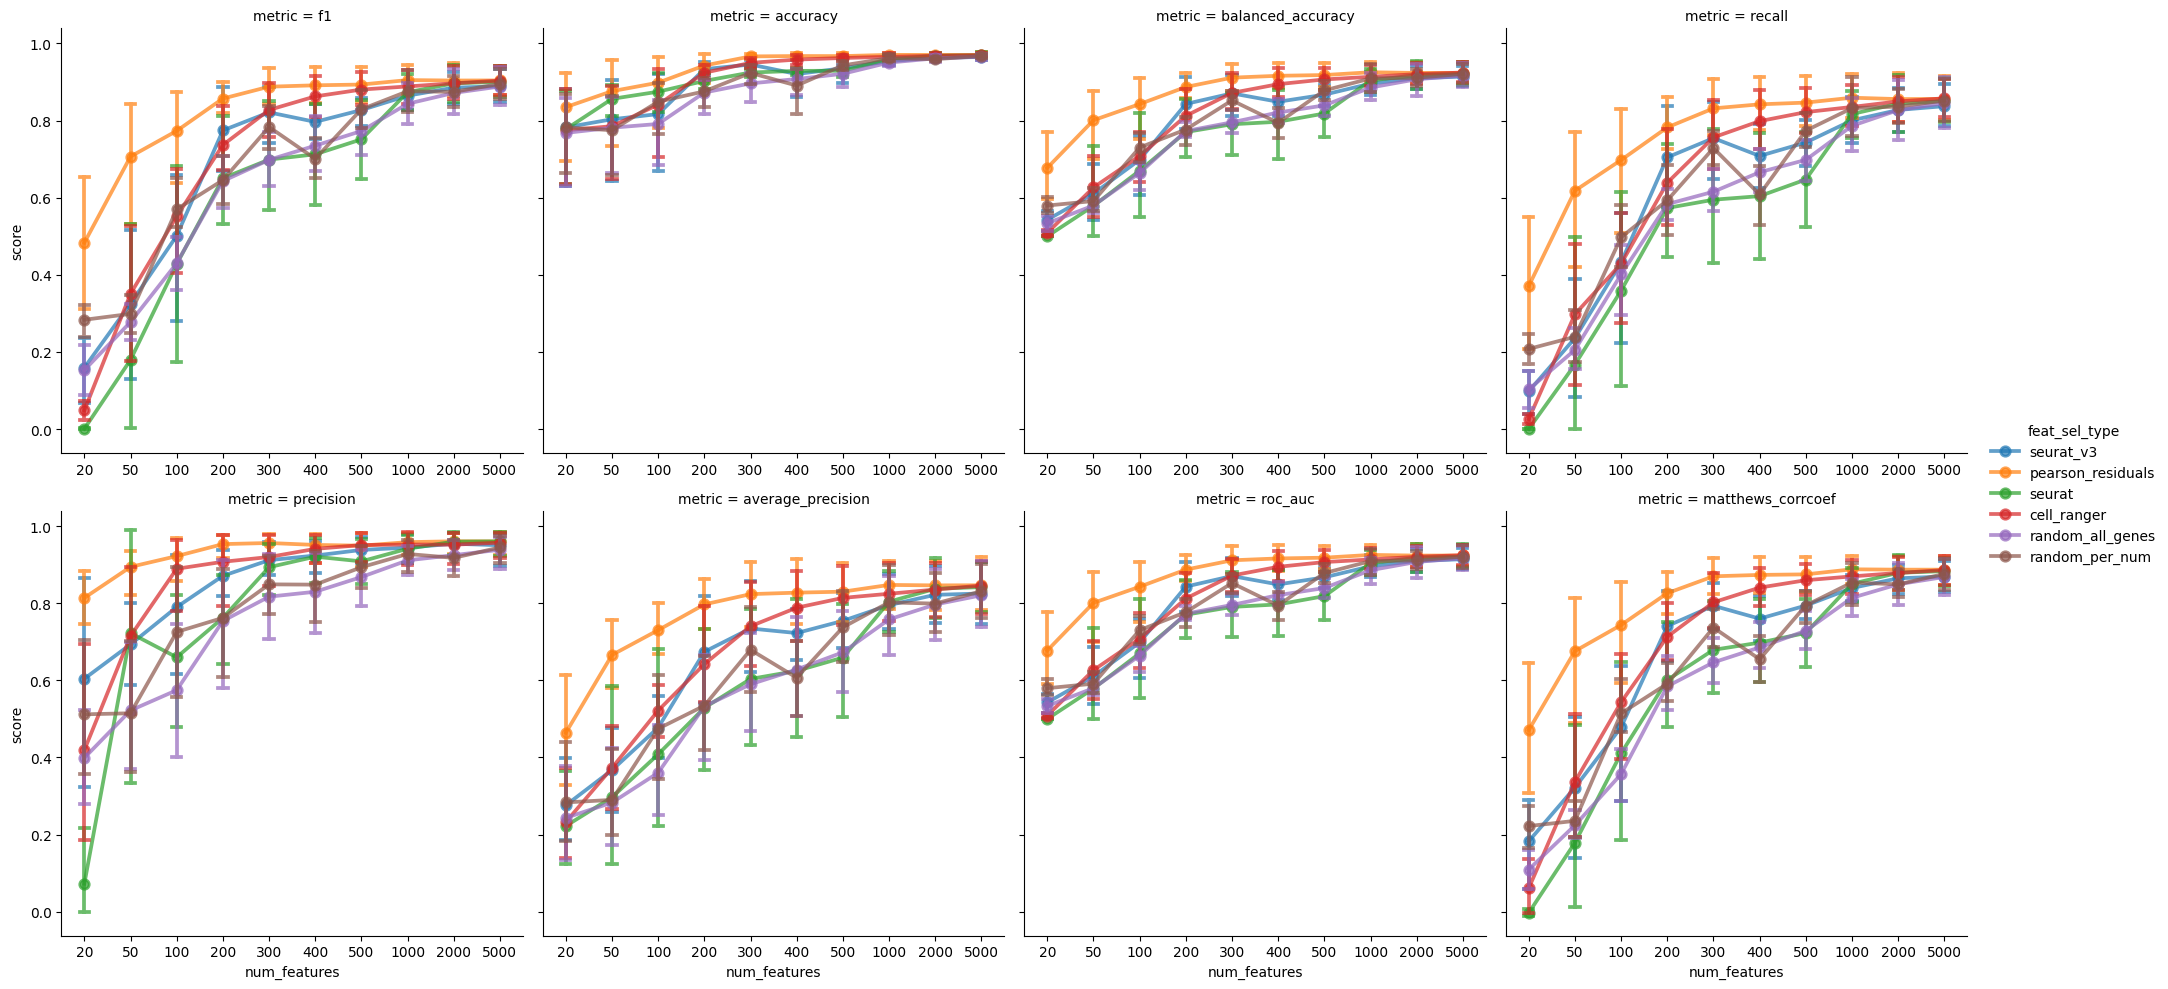

In [ ]:
# Plot performance metrics
results_df_pivot, fig = make_line_plots_metrics(results_df)
#results_df_pivot.to_csv('results_df_pivot_20241118.csv')
fig.savefig('metrics_comparison_20241118.png')

Main findings

* Comparison of methods
  * Differential gene expression (DGE) performs best until about 200 genes
  * For 200+ genes, DGE and analytic Pearson residuals have similar results
* Optimal number of features:
  * See sharp increase in scores until ~200-300, after which there is a gradual increase in scores

Conclusions:
* Use DGE or analytic Pearson residuals with 200 genes



**Feature importance**

* Identify most important features in each fold
* Compare between different methods? Want to understand why analytic Pearson residuals outperforms other methods

In [ ]:
# Loop through to plot
# num_features = [20, 50, 100, 200, 300, 5000]
# feat_sel_list = ['dge', 'seurat_v3', 'pearson_residuals', 'seurat', 'cell_ranger', 'random_all_genes']
num_features = [20, 100, 200, 300, 5000]
feat_sel_list = ['dge', 'pearson_residuals', 'random_all_genes']

for curr_method in feat_sel_list:,
    print(f'curr_method: {curr_method}')
    for curr_num in num_features:
        print(f'curr_num: {curr_num}')
        shap_vals_df = plot_feat_importance(adata, curr_method, curr_num,
                                       #   feat_order, shap_results, fold_index)
                                            feat_dict, shap_dict, fold_index_dict,
                                           'outputs/20241120/')


In [ ]:
    "# calculate Jaccard coefficient\n",
    "df = calc_jaccard_coeff(feat_sel_list, num_features, feat_dict, 5)\n",
    "df.tail()\n",
    "#df.to_csv('jaccard_df.csv')"

    "#df.sort_values('jaccard_coeff', ascending = False).head(20)\n",
    "\n",
    "# Average Jaccard coefficients across folds\n",
    "#df = pd.read_csv('jaccard_df.csv', index_col = 0)\n",
    "display(df.head())\n",
    "df_grp = df.groupby(['method1', 'method2', 'num_features'])['jaccard_coeff'].agg(['mean', 'std'])\n",
    "df_grp.to_csv('jaccard_coeff_grp_20241118.csv')"